In [34]:
import os
import numpy as np
#import laspy
import math
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Carpeta donde se encuentran las nubes originales que se van a partir y reducir

In [7]:
dataset_folder = 'las/' 
dataset_folder = 'las_test/' 

Carpeta donde se guardan las nubes resultantes

In [8]:
save_dir = "procesadas_main/"
save_dir = "test_split_normalized"

In [9]:
points_to_reduce = 16384

In [12]:
"""
import os
import laspy
import numpy as np

# Define the folder to save the sections
save_folder = "sections"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Open the LAS file
las_file = laspy.read("las/d2RCD-4-grafos-joint.las")

# Get the spatial extent of the LAS file
min_x, min_y, min_z = np.min(las_file.x), np.min(las_file.y), np.min(las_file.z)
max_x, max_y, max_z = np.max(las_file.x), np.max(las_file.y), np.max(las_file.z)
extent = np.array([min_x, min_y, max_x, max_y])

# Define the size of the smaller sections
section_size = 51.0  # meters

# Loop over the smaller sections
for x_min in np.arange(min_x, max_x, section_size):
    for y_min in np.arange(min_y, max_y, section_size):
        # Define the bounding box for this section
        x_max, y_max = x_min + section_size, y_min + section_size
        section_extent = np.array([x_min, y_min, x_max, y_max])

        # Find the points that are inside the section
        section_indices = np.where((las_file.x >= x_min) & (las_file.x < x_max) & 
                                   (las_file.y >= y_min) & (las_file.y < y_max))[0]

        # If there are points inside the section, save a new LAS file
        if len(section_indices) > 0:
            section = las_file[section_indices]
            section_filename = f"section_{x_min:.2f}_{y_min:.2f}.npy"
            section_data = np.vstack((section.x, section.y, section.z)).T
            np.save(os.path.join(save_folder, section_filename), section_data)
"""


Separación en grillas original

In [15]:
adapta_clases = las.classification
print(adapta_clases)
print(type(adapta_clases))

<SubFieldView([1 1 1 ... 1 1 1])>
<class 'laspy.point.dims.SubFieldView'>


In [28]:
xyzic

array([[4.32057450e+05, 4.59822362e+06, 6.71200000e+01, 9.47000000e+02,
        0.00000000e+00],
       [4.32057390e+05, 4.59822347e+06, 6.71400000e+01, 7.06000000e+02,
        0.00000000e+00],
       [4.32058540e+05, 4.59822432e+06, 6.71500000e+01, 9.65000000e+02,
        0.00000000e+00],
       ...,
       [4.31642700e+05, 4.59950037e+06, 7.82600000e+01, 4.70000000e+02,
        0.00000000e+00],
       [4.31646010e+05, 4.59950102e+06, 7.83700000e+01, 6.07000000e+02,
        0.00000000e+00],
       [4.31641900e+05, 4.59949977e+06, 7.82800000e+01, 5.73000000e+02,
        0.00000000e+00]])

In [10]:
for filename in os.listdir(dataset_folder):
    f = os.path.join(dataset_folder, filename)
    if os.path.isfile(f):
        las = laspy.read(f)
        
        point_data = np.stack([las.x, las.y, las.z], axis=0) #.transpose((1, 0))


        #clases_a_reducir = np.array(las.classification)

        # Identify indices of points with classification not in [1,8]
        #indices_to_remove = np.where(np.logical_or(clases_a_reducir < 1, clases_a_reducir > 8))[0]

        # Remove points with classification not in [1,8] from the arrays
        #nuevos_puntos = np.delete(nuevos_puntos, indices_to_remove, axis=0)
        #xyzic = np.delete(xyzic, indices_to_remove, axis=0)

        #print(np.unique(clases_a_reducir))
        #xyz = np.stack([las.x, las.y, las.z], axis=0).transpose((1, 0))

        adapta_clases = las.classification
        adapta_clases = np.subtract(adapta_clases, 1)

        xyzic = np.stack([las.x, las.y, las.z, las.intensity, adapta_clases], axis=0).transpose((1, 0))
        xyz = np.stack([las.x, las.y, las.z], axis=0).transpose((1, 0))

        #xyzic = np.stack([las.x, las.y, las.z, las.intensity, las.classification], axis=0).transpose((1, 0))
        #once i have created this array i want to delete all the values which are not beteween 1 and 8 of the 4th colum which is las.classification and its corresponding positions to all the rows

        valid_rows = (xyzic[:, 4] >= 0) & (xyzic[:, 4] <= 7)

        # delete rows where classification is not between 1 and 8
        xyzic = np.delete(xyzic, np.where(~valid_rows), axis=0)

        def borrar_ignorados(arr, valores_borrar, column_index):
            #column_index = 4
            # Especificar el valor que quieres eliminar
            #valores_borrar = [0,15,21,27]
            for value_to_delete in valores_borrar:
                # Crear una máscara booleana para identificar las filas a eliminar
                mask = arr[:, column_index] == value_to_delete
                # Eliminar las filas que cumplen la condición
                arr = np.delete(arr, np.where(mask), axis=0)
                return arr
        
        nuevos_puntos = borrar_ignorados(xyzic, [10,15,21,27,255], 4) #0

        all_x = point_data[0]
        all_y = point_data[1]
        all_z = point_data[2]

        x_min = np.memmap.min(all_x)
        x_max = np.memmap.max(all_x)
        y_min = np.memmap.min(all_y)
        y_max = np.memmap.max(all_y)
        z_min = np.memmap.min(all_z)
        z_max = np.memmap.max(all_z)

        len_split = 51  #25000  #the length you want to have in each fragment of new division of pointcloud

        divide_x_in = math.floor((x_max-x_min) / len_split) #cogemos el de arriba para asegurar tener todo. quiza los trozos no son de 50x50 sino 49.8x49.9ç
        divide_y_in = math.floor((y_max-y_min) / len_split) #cogemos el de arriba para asegurar tener todo. quiza los trozos no son de 50x50 sino 49.8x49.9ç

        print(divide_x_in)
        print(divide_y_in)
    
        x_grid = np.linspace(x_min, x_max, divide_x_in + 1)
        y_grid = np.linspace(y_min, y_max, divide_y_in + 1)

        count = 0

        for i in range(len(x_grid)-1):
            for j in range(len(y_grid)-1):
                if count <= len(y_grid)-1: 
                    mask_x = np.logical_and(nuevos_puntos[:,0] >= x_grid[i], nuevos_puntos[:,0] <= x_grid[i+1])
                else: 
                    mask_x = np.logical_and(nuevos_puntos[:,0] >= x_grid[i], nuevos_puntos[:,0] < x_grid[i+1])
                count += 1
                
                filtered_x = nuevos_puntos[mask_x]
                
                mask_y = np.logical_and(filtered_x[:,1] >= y_grid[j], filtered_x[:,1] < y_grid[j+1])
                filtered_y = filtered_x[mask_y]
                np.savetxt('filteredy.out', filtered_y)
                if(len(filtered_y)> points_to_reduce):

                    reduccion = np.random.choice(len(filtered_y), size=points_to_reduce, replace=True)
                    reducido = filtered_y[reduccion]
                    #np.save(os.path.join(save_dir, os.path.splitext(filename)[0]+f"_{str(count).zfill(3)}"), reducido)
                else:
                    if(len(filtered_y)>0):
                        print(filtered_y)
                        print(filtered_y.shape)
                        #np.save(os.path.join(save_dir, os.path.splitext(filename)[0]+f"_NO16384_{str(count).zfill(3)}"), filtered_y)
                    #else:
                        #print("NO SE GUARDO POR VACIO-> ", os.path.join(save_dir, os.path.splitext(filename)[0]+f"_NO16384_{str(count).zfill(3)}"))


21
27
[[4.31341790e+05 4.59934653e+06 8.54900000e+01 1.65000000e+03
  7.00000000e+00]
 [4.31342110e+05 4.59934662e+06 8.53400000e+01 1.63700000e+03
  7.00000000e+00]
 [4.31341720e+05 4.59934634e+06 8.55500000e+01 1.63700000e+03
  7.00000000e+00]
 ...
 [4.31343820e+05 4.59932415e+06 7.83400000e+01 1.68500000e+03
  0.00000000e+00]
 [4.31343880e+05 4.59932405e+06 7.83300000e+01 1.66300000e+03
  0.00000000e+00]
 [4.31343850e+05 4.59932392e+06 7.83300000e+01 1.65200000e+03
  0.00000000e+00]]
(912, 5)
[[4.31307490e+05 4.59939752e+06 7.89400000e+01 1.71500000e+03
  0.00000000e+00]
 [4.31308070e+05 4.59939768e+06 7.89500000e+01 1.65600000e+03
  0.00000000e+00]
 [4.31307380e+05 4.59939733e+06 7.89400000e+01 1.68900000e+03
  0.00000000e+00]
 ...
 [4.31342080e+05 4.59934690e+06 8.53000000e+01 1.72000000e+03
  7.00000000e+00]
 [4.31341950e+05 4.59934673e+06 8.54100000e+01 1.59300000e+03
  7.00000000e+00]
 [4.31342210e+05 4.59934681e+06 8.52500000e+01 1.65800000e+03
  7.00000000e+00]]
(16025, 5)
[[

KeyboardInterrupt: 

Recontrucción de Nube

In [8]:
las_dir = save_dir

datos_fragmentos = []

for filename in os.listdir(las_dir):
    if filename.endswith('.npy'):
        #data = np.load(las_dir+filename)
        datos_fragmentos.append(np.load(las_dir+filename))

# concatenamos todos los datos de los fragmentos en una única matriz
nube_de_puntos = np.vstack(datos_fragmentos)

# guardamos la nube de puntos resultante como un archivo .npy
np.save("nube_de_puntos_reconstruida.npy", nube_de_puntos)

In [3]:
import os
import numpy as np
#import laspy
import math
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Visualización de Fichero .npy

In [36]:
MisColores = {
    1: np.array([0.5,0.25,0]), #terreno
    2: np.array([0.1,0.6,0]),  #vegetación
    3: np.array([0.99,0,0]), #coche
    4: np.array([0.5,0.5,0.5]), #torre
    5: np.array([0.99,0,0.99]), #cable
    6: np.array([0.6,0.4,0.6]), #valla/muro
    7: np.array([0.99,0.99,0]), #farola
    8: np.array([0.15,0.09,0.9]), #edificio
}


MisColores = {
    0: np.array([0.5,0.25,0]), #terreno
    1: np.array([0.1,0.6,0]),  #vegetación
    2: np.array([0.99,0,0]), #coche
    3: np.array([0.5,0.5,0.5]), #torre
    4: np.array([0.99,0,0.99]), #cable
    5: np.array([0.6,0.4,0.6]), #valla/muro
    6: np.array([0.99,0.99,0]), #farola
    7: np.array([0.15,0.09,0.9]), #edificio
}


#data = np.load('../Datasets/Aerolaser/train/train/procesados50000-0_1/1-celra-grafos_005.npy')
#data = np.load('../Datasets/Aerolaser/test/procesados16384-0_1/d2RCD-4-grafos-joint_186.npy')
#data = np.load('../Datasets/Aerolaser/overfit50k-1/1-celra-grafos_067.npy')


#data = np.load('C:/Users/sfernandez/nueva_etapa/github2/LidarSegmentationPytorch/Datasets/ParisLille/train/train/procesados4096-0_1/Paris_013.npy')
data = np.load('C:/Users/sfernandez/nueva_etapa/github2/LidarSegmentationPytorch/Datasets/ParisLille/train/train/procesados4096-0_1/Paris.ply_64.npy')
print("SHAPE DE DATATATATAT->", data.shape)
#data = np.load('C:/Users/sfernand
# las_dir = 'procesadas_main/'ez/nueva_etapa/moviendoAlServidor/Pointnet2Aerolaser/nuevaparticion/train/train/procesados50-1_1/5190_54400_089.npy')



"""
las_dir = 'procesadas_main/'
las_dir = '../Datasets/Aerolaser/train/train/procesados16384-0_1/'
las_dir = 'C:/Users/sfernandez/nueva_etapa/spliteando_datasets/cortados/'
for filename in os.listdir(las_dir):
    if filename.endswith('.npy'):
        data = np.load(las_dir+filename)   #'procesadas_main/d2RCD-4-grafos-joint_025.npy')
        print(filename)
"""

#data = np.load('procesadas_main/d2RCD-4-grafos-joint_NO16384_001.npy')   
#data = np.load('procesadas_main/d2RCD-4-grafos-joint_NO16384_001.npy') 
#data = np.load('procesadas_main/buenaschano/1-celra-grafos-joint-3.npy')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
c = data[:, 4].astype(int)
r = data[:, 3]

points = data[:, 0:3]

print(np.unique(c))
print(c)
print(len(x))

ocurrencias = {}
for numero in c:
    if numero in ocurrencias:
        ocurrencias[numero] += 1
    else:
        ocurrencias[numero] = 1

for numero, conteo in ocurrencias.items():
    print(f"El número {numero} aparece {conteo} veces.")

# Assign colors to each point based on the corresponding value in the c array
colors = np.zeros_like(points)
for i, value in MisColores.items():
    mask = (c == i)
    colors[mask] = value

cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)  
cloud.colors = o3d.utility.Vector3dVector(colors)
print(colors)
o3d.visualization.draw_geometries([cloud])

SHAPE DE DATATATATAT-> (4096, 5)


IndexError: index 4 is out of bounds for axis 1 with size 3

Split Train Test

[]


UNIFICAR DATASET

In [2]:
import os
import numpy as np
import laspy
import math
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [35]:
import time
las_dir = r'C:/Users/sfernandez/nueva_etapa/moviendoAlServidor/Pointnet2Aerolaser/dataset_final_pruebas_balanceo_5/test/'  #train/'
las_dir = r'C:/Users/sfernandez/nueva_etapa/moviendoAlServidor/kopa/RandLA-Net-pytorch/dataset_crudo_partido/train/celra/' #

las_dir = r'C:/Users/sfernandez/nueva_etapa/moviendoAlServidor/Pointnet2Aerolaser/nuevaparticion/celranuevo/'  #train/'

las_dir = r'C:/Users/sfernandez/nueva_etapa/moviendoAlServidor/Pointnet2Aerolaser/nuevaparticion/train/train/procesados4K-1_1/prueba/'

las_dir = r'C:/Users/sfernandez/nueva_etapa/github2/LidarSegmentationPytorch/Datasets/Aerolaser/test/procesados4096-0_1/'


datos_fragmentos = []

for filename in os.listdir(las_dir):
    if filename.endswith('.npy'):
        #data = np.load(las_dir+filename)

        nubetemp = np.load(las_dir+filename)
        print(len(nubetemp))

        npoints = 16384
        choice = np.random.choice(nubetemp.shape[0], npoints, replace=True)
        nubetemp = nubetemp[choice, :]#, c[choice]

        datos_fragmentos.append(nubetemp)
        

# concatenamos todos los datos de los fragmentos en una única matriz
nube_de_puntos = np.vstack(datos_fragmentos)

# guardamos la nube de puntos resultante como un archivo .npy
np.save("nube_de_puntos_reconstruidaNUEVA.npy", nube_de_puntos)

#############
#############
##############
##############

MisColores = {
    1: np.array([0.5,0.25,0]), #terreno
    2: np.array([0.1,0.6,0]),  #vegetación
    3: np.array([0.99,0,0]), #coche
    4: np.array([0.5,0.5,0.5]), #torre
    5: np.array([0.99,0,0.99]), #cable
    6: np.array([0.6,0.4,0.6]), #valla/muro
    7: np.array([0.99,0.99,0]), #farola
    8: np.array([0.15,0.09,0.9]), #edificio
}

MisColores = {
    0: np.array([0.5,0.25,0]), #terreno
    1: np.array([0.1,0.6,0]),  #vegetación
    2: np.array([0.99,0,0]), #coche
    3: np.array([0.5,0.5,0.5]), #torre
    4: np.array([0.99,0,0.99]), #cable
    5: np.array([0.6,0.4,0.6]), #valla/muro
    6: np.array([0.99,0.99,0]), #farola
    7: np.array([0.15,0.09,0.9]), #edificio
}

data = np.load('nube_de_puntos_reconstruidaNUEVA.npy')

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
c = data[:, 4].astype(int)
r = data[:, 3]

points = data[:, 0:3]



print(np.unique(c))
print(c)
print(len(x))

ocurrencias = {}
for numero in c:
    if numero >= 0 and numero <= 7:
        if numero in ocurrencias:
            ocurrencias[numero] += 1
        else:
            ocurrencias[numero] = 1

for numero in range(8):
    conteo = ocurrencias.get(numero, 0)
    print(f"El número {numero} aparece {conteo} veces.")

# Assign colors to each point based on the corresponding value in the c array
colors = np.zeros_like(points)
for i, value in MisColores.items():
    mask = (c == i)
    colors[mask] = value



#choice = np.random.choice(points.shape[0], 32768, replace=True)
#points, colors = points[choice, :], colors[choice]
cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)
cloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([cloud])

4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096
4096


DOWNSAMPLE POR VOXELES FUNCIONANDO POR FIN!!!! + normalizacion

In [22]:
opt_dataset_type = 'train'
def normalize_dataset(data, filename_seg):
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    r = data[:, 3]
    c = data[:, 4]

    x_normalized1 = (x-min(x))
    x_normalized = x_normalized1/max(x_normalized1)

    y_normalized1 = (y-min(y))
    y_normalized = y_normalized1/max(y_normalized1)

    z_normalized1 = (z-min(z))
    z_normalized = z_normalized1/100

    """
    if(opt_dataset_type == 'test'):

        max_normalized_x_all_array = np.full(len(c), max(x_normalized1))
        max_normalized_y_all_array = np.full(len(c), max(y_normalized1))
        min_x_all_array = np.full(len(c), min(x))
        min_y_all_array = np.full(len(c), min(y))
        min_z_all_array = np.full(len(c), min(z))

        xyzrc_normalized = np.array([x_normalized,y_normalized,z_normalized,r,c,
                                     max_normalized_x_all_array, max_normalized_y_all_array, 
                                     min_x_all_array, min_y_all_array, min_z_all_array]).T #max(x_normalized), max(y_normalized), min(x), min(y), min(z)]).T
        
        np.save(os.path.join(test_dataset_folder, filename_seg), xyzrc_normalized)
    """
    if(opt_dataset_type == 'train'):

        xyzrc_normalized = np.array([x_normalized,y_normalized,z_normalized,r,c]).T #max(x_normalized), max(y_normalized), min(x), min(y), min(z)]).T
        return xyzrc_normalized
        #np.save(os.path.join(train_dataset_folder, filename_seg), xyzrc_normalized)

In [37]:
import time 
import random

las_dir = r'C:/Users/sfernandez/nueva_etapa/moviendoAlServidor/Pointnet2Aerolaser/nuevaparticion/celranuevo/'  #train/'

datos_fragmentos = []

for filename in os.listdir(las_dir):
    if filename.endswith('.npy'):
        #data = np.load(las_dir+filename)

        nubetemp = np.load(las_dir+filename)
        #print(nubetemp)
        #time.sleep(10)

        npoints = 16384
        choice = np.random.choice(nubetemp.shape[0], npoints, replace=True)
        randomNube = nubetemp[choice, :]#, c[choice]

        #####

        x = nubetemp[:, 0]
        y = nubetemp[:, 1]
        z = nubetemp[:, 2]

        voxel_size = 1  # Adjust this value based on your requirements
        voxel_indices = ((x / voxel_size).astype(int), (y / voxel_size).astype(int), (z / voxel_size).astype(int))

        voxel_dict = {}
        for i in range(nubetemp.shape[0]):
            voxel_index = voxel_indices[0][i], voxel_indices[1][i], voxel_indices[2][i]
            if voxel_index in voxel_dict:
                voxel_dict[voxel_index].append(nubetemp[i])
            else:
                voxel_dict[voxel_index] = [nubetemp[i]]

        fixed_num_points = 16384  # Adjust this value based on your requirements
        num_points_per_voxel = int(np.ceil(fixed_num_points / len(voxel_dict)))

        downsampled_points = []
        voxel_indices = set(zip(*voxel_indices))

        num_points_per_voxel = int(np.ceil(fixed_num_points / len(voxel_indices)))

        for voxel_index in voxel_indices:
            voxel_points = voxel_dict.get(voxel_index, [])
            if len(voxel_points) <= num_points_per_voxel:
                downsampled_points.extend(voxel_points)
            else:
                random_indices = random.sample(range(len(voxel_points)), num_points_per_voxel)
                downsampled_points.extend(np.array(voxel_points)[random_indices])

        downsampled_points = np.array(downsampled_points[:fixed_num_points])
        
        #print(len(downsampled_points))

        datos_fragmentos.append(downsampled_points)

        #PuntosNatural:    10584984
        #PuntosVoxelizada: 1384677 
        #PuntosRandom:     1622016


        ###IMPORTANTE
        #Normalizacion
        #downsampled_points = normalize_dataset(downsampled_points, filename)



        # concatenando

nube_de_puntos = np.vstack(datos_fragmentos)
print(len(nube_de_puntos))

#VISUALIZAR NUBE ENTERA VOXELIZADAS IN GUARDAR
x = nube_de_puntos[:, 0]
y = nube_de_puntos[:, 1]
z = nube_de_puntos[:, 2]
c = nube_de_puntos[:, 4].astype(int)
r = nube_de_puntos[:, 3]

points = nube_de_puntos[:, 0:3]

# Assign colors to each point based on the corresponding value in the c array
colors = np.zeros_like(points)
for i, value in MisColores.items():
    mask = (c == i)
    colors[mask] = value

#choice = np.random.choice(points.shape[0], 32768, replace=True)
#points, colors = points[choice, :], colors[choice]
cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)
cloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([cloud])

#guardando antes de normalizar
#np.save("VoxelizadaJunta.npy", nube_de_puntos)

        ####
        #Normalizacion
        #downsampled_points = normalize_dataset(downsampled_points, filename)
        
        ###
"""
#################
#################
#################
#################
#VISUALIZADOR TEMPORAL VOXELIZADO
MisColores = {
    0: np.array([0.5,0.25,0]), #terreno
    1: np.array([0.1,0.6,0]),  #vegetación
    2: np.array([0.99,0,0]), #coche
    3: np.array([0.5,0.5,0.5]), #torre
    4: np.array([0.99,0,0.99]), #cable
    5: np.array([0.6,0.4,0.6]), #valla/muro
    6: np.array([0.99,0.99,0]), #farola
    7: np.array([0.15,0.09,0.9]), #edificio
}

x = downsampled_points[:, 0]
y = downsampled_points[:, 1]
z = downsampled_points[:, 2]
c = downsampled_points[:, 4].astype(int)
r = downsampled_points[:, 3]

points = downsampled_points[:, 0:3]

# Assign colors to each point based on the corresponding value in the c array
colors = np.zeros_like(points)
for i, value in MisColores.items():
    mask = (c == i)
    colors[mask] = value

#choice = np.random.choice(points.shape[0], 32768, replace=True)
#points, colors = points[choice, :], colors[choice]
cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)
cloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([cloud])
"""
####
###########
################
####################
###################
##############################
#################


        #
        #npoints = 16384
        #choice = np.random.choice(nubetemp.shape[0], npoints, replace=True)
        #nubetemp = nubetemp[choice, :]#, c[choice]

        #datos_fragmentos.append(nubetemp)



"""
#data = np.load(las_dir+filename)
datos_fragmentos.append(np.load(las_dir+filename))

# concatenamos todos los datos de los fragmentos en una única matriz
nube_de_puntos = np.vstack(datos_fragmentos)

# guardamos la nube de puntos resultante como un archivo .npy
np.save("nube_de_puntos_reconstruidaNUEVA.npy", nube_de_puntos)

#############
#############
##############
##############

MisColores = {
    1: np.array([0.5,0.25,0]), #terreno
    2: np.array([0.1,0.6,0]),  #vegetación
    3: np.array([0.99,0,0]), #coche
    4: np.array([0.5,0.5,0.5]), #torre
    5: np.array([0.99,0,0.99]), #cable
    6: np.array([0.6,0.4,0.6]), #valla/muro
    7: np.array([0.99,0.99,0]), #farola
    8: np.array([0.15,0.09,0.9]), #edificio
}

MisColores = {
    0: np.array([0.5,0.25,0]), #terreno
    1: np.array([0.1,0.6,0]),  #vegetación
    2: np.array([0.99,0,0]), #coche
    3: np.array([0.5,0.5,0.5]), #torre
    4: np.array([0.99,0,0.99]), #cable
    5: np.array([0.6,0.4,0.6]), #valla/muro
    6: np.array([0.99,0.99,0]), #farola
    7: np.array([0.15,0.09,0.9]), #edificio
}

data = np.load('nube_de_puntos_reconstruidaNUEVA.npy')

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
c = data[:, 4].astype(int)
r = data[:, 3]

points = data[:, 0:3]

print(np.unique(c))
print(c)
print(len(x))

ocurrencias = {}
for numero in c:
    if numero >= 0 and numero <= 7:
        if numero in ocurrencias:
            ocurrencias[numero] += 1
        else:
            ocurrencias[numero] = 1

for numero in range(8):
    conteo = ocurrencias.get(numero, 0)
    print(f"El número {numero} aparece {conteo} veces.")

# Assign colors to each point based on the corresponding value in the c array
colors = np.zeros_like(points)
for i, value in MisColores.items():
    mask = (c == i)
    colors[mask] = value



#choice = np.random.choice(points.shape[0], 32768, replace=True)
#points, colors = points[choice, :], colors[choice]
cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)
cloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([cloud])
"""

1384677


'\n#data = np.load(las_dir+filename)\ndatos_fragmentos.append(np.load(las_dir+filename))\n\n# concatenamos todos los datos de los fragmentos en una única matriz\nnube_de_puntos = np.vstack(datos_fragmentos)\n\n# guardamos la nube de puntos resultante como un archivo .npy\nnp.save("nube_de_puntos_reconstruidaNUEVA.npy", nube_de_puntos)\n\n#############\n#############\n##############\n##############\n\nMisColores = {\n    1: np.array([0.5,0.25,0]), #terreno\n    2: np.array([0.1,0.6,0]),  #vegetación\n    3: np.array([0.99,0,0]), #coche\n    4: np.array([0.5,0.5,0.5]), #torre\n    5: np.array([0.99,0,0.99]), #cable\n    6: np.array([0.6,0.4,0.6]), #valla/muro\n    7: np.array([0.99,0.99,0]), #farola\n    8: np.array([0.15,0.09,0.9]), #edificio\n}\n\nMisColores = {\n    0: np.array([0.5,0.25,0]), #terreno\n    1: np.array([0.1,0.6,0]),  #vegetación\n    2: np.array([0.99,0,0]), #coche\n    3: np.array([0.5,0.5,0.5]), #torre\n    4: np.array([0.99,0,0.99]), #cable\n    5: np.array([0.6,0.4

['INFO:root:[Epoch', '0]', 'Validation', 'Loss:', '1.0288', 'Validation', 'Accuracy:', '0.6158']
['INFO:root:[Epoch', '1]', 'Validation', 'Loss:', '0.8397', 'Validation', 'Accuracy:', '0.6900']
['INFO:root:[Epoch', '2]', 'Validation', 'Loss:', '0.7942', 'Validation', 'Accuracy:', '0.6955']
['INFO:root:[Epoch', '3]', 'Validation', 'Loss:', '0.6829', 'Validation', 'Accuracy:', '0.7796']
['INFO:root:[Epoch', '4]', 'Validation', 'Loss:', '0.7178', 'Validation', 'Accuracy:', '0.7190']
['INFO:root:[Epoch', '5]', 'Validation', 'Loss:', '0.7524', 'Validation', 'Accuracy:', '0.7491']
['INFO:root:[Epoch', '6]', 'Validation', 'Loss:', '0.7666', 'Validation', 'Accuracy:', '0.6792']
['INFO:root:[Epoch', '7]', 'Validation', 'Loss:', '0.6588', 'Validation', 'Accuracy:', '0.7176']
['INFO:root:[Epoch', '8]', 'Validation', 'Loss:', '0.6633', 'Validation', 'Accuracy:', '0.7778']
['INFO:root:[Epoch', '9]', 'Validation', 'Loss:', '1.0437', 'Validation', 'Accuracy:', '0.6727']
['INFO:root:[Epoch', '10]', 'V

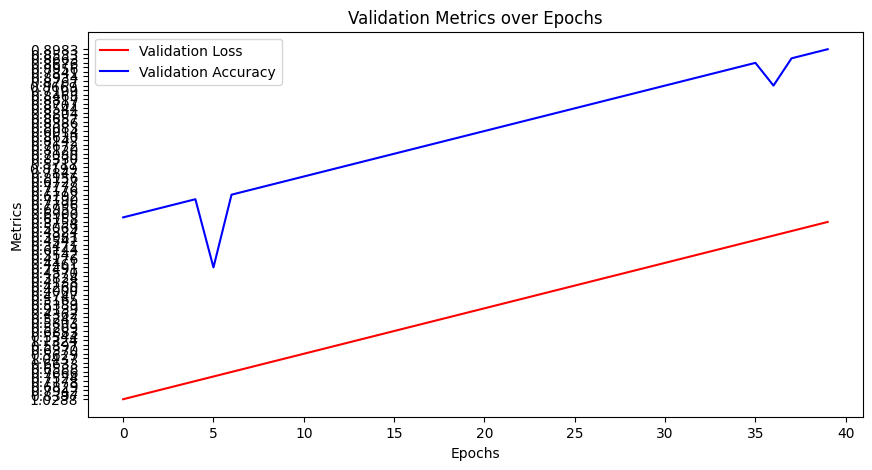

In [31]:
import matplotlib.pyplot as plt
import re
file_path = 'C:/Users/sfernandez/nueva_etapa/presentaciones/sprint1.1/06-02-2023/ultimodeparislilleconloslogs/ValLossAcc.txt'

import matplotlib.pyplot as plt

# Extraer datos del archivo de texto
with open(file_path, 'r') as f:
    lines = f.readlines()

epochs = []
val_losses = []
val_accs = []

for line in lines:
    if 'Epoch' in line:
        parts = line.split()
        print(parts)

        epoch = int(parts[1][:-1])
        loss = parts[4]
        acc = parts[7]
        epochs.append(epoch)
        val_losses.append(loss)
        val_accs.append(acc)


# Crear gráficos
plt.figure(figsize=(10,5))

plt.plot(epochs, val_losses, color='red', label='Validation Loss')
plt.plot(epochs, val_accs, color='blue', label='Validation Accuracy')

plt.title('Validation Metrics over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.show()